In [1]:
pwd

'/data2/mito_lineage/src/vireo'

In [2]:
import os
os.chdir("/data2/mito_lineage")

In [3]:
from os.path import join, exists, dirname
from glob import glob
import pickle
import mplh.cluster_help as ch
import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

from src.external.pyvenn import venn


%load_ext autoreload
%autoreload 2
import src.utils.variant_utils as vu
from src.utils.data_io import wrap_load_mtx_df
from src.utils.variant_utils import filt_high, filt_low
from icecream import ic

0.5.6


In [4]:
INDIR = "output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_simple/vireo/nclones20/"
OUTDIR = "output/pipeline/cd34norm/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_simple/vireo/nclones20/qc"
N_DONORS=2
vars_to_plot=10
sample_names="pre,post"
n_clones=20
var_thresh = 0.001
vcf_f=None

In [6]:
cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), sep='\t').set_index("ID")
cells_meta

,Unnamed: 0,level_0,index,raw ID,new index,condition,donor,donor_index,lineage,lineage_index
ID,,,,,,,,,,
AAACGAAAGTCGTGAG-1_Control,0,2,2,AAACGAAAGTCGTGAG-1,3,Control,0,1,NaN,NaN
AAACGAACACAATAAG-1_Control,1,4,4,AAACGAACACAATAAG-1,5,Control,0,2,NaN,NaN
AAACGAAGTAAGTCTC-1_Control,2,9,9,AAACGAAGTAAGTCTC-1,10,Control,0,3,NaN,NaN
AAACGAAGTGGATTCT-1_Control,3,12,12,AAACGAAGTGGATTCT-1,13,Control,0,4,NaN,NaN
AAACGAATCGCAACTA-1_Control,4,14,14,AAACGAATCGCAACTA-1,15,Control,0,5,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...
TTTGGTTGTTAACCAC-1_Flt3l,3746,17371,17371,TTTGGTTGTTAACCAC-1,17372,Flt3l,3,3747,18.0,174.0
TTTGTGTAGAGAGTAG-1_Flt3l,3747,17378,17378,TTTGTGTAGAGAGTAG-1,17379,Flt3l,3,3748,NaN,NaN
TTTGTGTGTATTCTGG-1_Flt3l,3748,17394,17394,TTTGTGTGTATTCTGG-1,17395,Flt3l,3,3749,NaN,NaN


In [18]:
counts = cells_meta.groupby(["condition", "donor"]).size().reset_index()
counts

,condition,donor,0
0,Control,0,1623
1,Control,1,1233
2,Control,2,1411
3,Control,3,1340
4,Flt3l,0,2582
5,Flt3l,1,2620
6,Flt3l,2,1662
7,Flt3l,3,2411


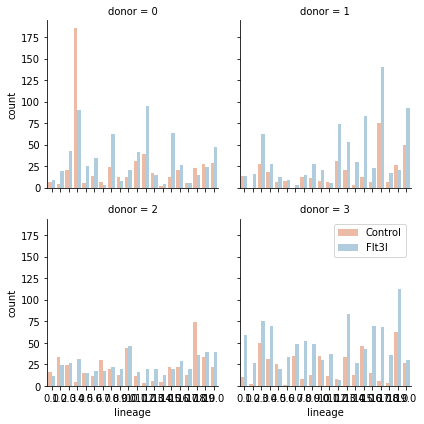

In [17]:
g = sns.FacetGrid(cells_meta, col="donor", col_wrap=2)
g.map_dataframe(sns.countplot, x="lineage", hue="condition", palette="RdBu")
plt.legend()